In [1]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
import choix

In [2]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "font.size": 15})
# for Palatino and other serif fonts use:
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Palatino"],
# })

In [3]:
import ladyns as ldn

## Simulation Function

In [4]:
def simulate(d, w_star, A):
    data = []
    for i in np.arange(d-1):
        for j in np.arange(i+1, d):
            p = 1 / (1 + np.exp(w_star[i]-w_star[j])) # the probability that j wins i
            for _ in np.arange(A[i,j].astype(int)):
                res = np.random.binomial(1, p)
                if res < 0.5: # i wins j
                    data.append((i, j))
                else: # j wins i
                    data.append((j, i))
    
    w_hat = choix.ilsr_pairwise(d, data)
    
    return w_hat, np.sum((w_star - w_hat)**2)

# 1 Complete Graph

## parameters

In [132]:
d = 100
B = 1
T = 20

In [133]:
ds = (np.exp(np.linspace(-1,0,11))*d).astype(int)
n_iter = 100

## 1.1 Gaussian Distributed Score

## simulation

In [135]:
l2es = np.zeros((len(ds), n_iter))
lambdas_2_I = np.zeros((len(ds), n_iter))
lambdas_2_L = np.zeros((len(ds)))
kappa = np.zeros((len(ds), n_iter))
for i, d in enumerate(ds):
    print("%d-th d: %d"%(i, d))
    
    A_matrix = (np.arange(d)[:,None] != np.arange(d)) * T
    L_matrix = (np.diag(np.sum(A_matrix,0)) - A_matrix) # / np.sum(A_matrix) * 2
    u, v = la.eigh(L_matrix)
    L_isqrt = v @ (np.concatenate([[0], 1/np.sqrt(u[1:])])*v).T
    lambdas_2_L[i] = la.eigvalsh(L_matrix)[1]

    for j in np.arange(n_iter):
        w_star = np.random.normal(size=d)
        w_star = w_star - np.mean(w_star)
        w_star = w_star / np.max(np.abs(w_star))
        
        _, l2e = simulate(d, w_star, A_matrix)
        l2es[i,j] = l2e
        
        P_matrix = 1/(1+np.exp(w_star - w_star[:,None]))
        B_matrix = P_matrix * (1-P_matrix) * A_matrix
        I_matrix = (np.diag(np.sum(B_matrix,0)) - B_matrix) # / np.sum(A_matrix) * 2

        lambdas_2_I[i,j] = la.eigvalsh(I_matrix)[1]
        kappa[i,j] = 1/la.eigvalsh(L_isqrt @ I_matrix @ L_isqrt)[-1]

0-th d: 36
1-th d: 40
2-th d: 44
3-th d: 49
4-th d: 54
5-th d: 60
6-th d: 67
7-th d: 74
8-th d: 81
9-th d: 90
10-th d: 100


## plots

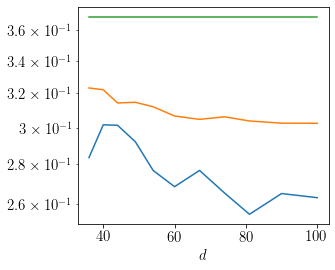

In [137]:
plt.figure(figsize=(4.5,4))
plt.plot(ds, np.quantile(l2es,0.95,axis=1), label=r'estimated')
# plt.plot(ds, np.mean(l2es,1))
# plt.fill_between(ds, np.mean(l2es,1) + 2*np.std(l2es,1)/np.sqrt(n_iter),
#                  np.mean(l2es,1) - 2*np.std(l2es,1)/np.sqrt(n_iter), alpha=0.3)
plt.plot(ds, ds*np.quantile(kappa/lambdas_2_I*np.exp(-1.3), 0.95, axis=1), label=r'this work')
plt.plot(ds, ds/lambdas_2_L*np.exp(2), label=r'Shah et al. (2016)')
plt.xlabel(r'$d$'); plt.yscale("log"); # plt.legend(loc='upper right')

# 2 Star Graph

## parameters

In [117]:
d = 20
B = 1
T = 200

In [118]:
ds = (np.exp(np.linspace(-1,0,11))*d).astype(int)
n_iter = 100

In [119]:
ds

array([ 7,  8,  8,  9, 10, 12, 13, 14, 16, 18, 20])

## 2.1 Gaussian Distributed Score

## simulation

In [120]:
l2es = np.zeros((len(ds), n_iter))
lambdas_2_I = np.zeros((len(ds), n_iter))
lambdas_2_L = np.zeros((len(ds)))
kappa = np.zeros((len(ds), n_iter))
for i, d in enumerate(ds):
    print("%d-th d: %d"%(i, d))
    
    A_matrix = np.logical_and(np.arange(d)[:,None] != np.arange(d),
                (np.maximum(np.arange(d)[:,None] * np.ones(d),
                            np.ones(d)[:,None] * np.arange(d)) < d/2) +
                (np.minimum(np.arange(d)[:,None] * np.ones(d),
                            np.ones(d)[:,None] * np.arange(d)) >= d/2) +
                (np.abs(np.arange(d)[:,None] - np.arange(d)) < 2))* T
    L_matrix = (np.diag(np.sum(A_matrix,0)) - A_matrix) # / np.sum(A_matrix) * 2
    u, v = la.eigh(L_matrix)
    L_isqrt = v @ (np.concatenate([[0], 1/np.sqrt(u[1:])])*v).T
    lambdas_2_L[i] = la.eigvalsh(L_matrix)[1]

    for j in np.arange(n_iter):
        w_star = np.random.normal(size=d)
        w_star = w_star - np.mean(w_star)
        w_star = w_star / np.max(np.abs(w_star))
        
        _, l2e = simulate(d, w_star, A_matrix)
        l2es[i,j] = l2e
        
        P_matrix = 1/(1+np.exp(w_star - w_star[:,None]))
        B_matrix = P_matrix * (1-P_matrix) * A_matrix
        I_matrix = (np.diag(np.sum(B_matrix,0)) - B_matrix) # / np.sum(A_matrix) * 2

        lambdas_2_I[i,j] = la.eigvalsh(I_matrix)[1]
        kappa[i,j] = 1/la.eigvalsh(L_isqrt @ I_matrix @ L_isqrt)[-1]

0-th d: 7
1-th d: 8
2-th d: 8
3-th d: 9
4-th d: 10
5-th d: 12
6-th d: 13
7-th d: 14
8-th d: 16
9-th d: 18
10-th d: 20


## plots

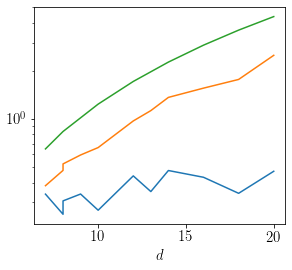

In [121]:
plt.figure(figsize=(4.5,4))
plt.plot(ds, np.quantile(l2es,0.95,axis=1), label=r'estimated')
# plt.fill_between(Ws, np.mean(l2es,1) + 2*np.std(l2es,1)/np.sqrt(n_iter),
#                 np.mean(l2es,1) - 2*np.std(l2es,1)/np.sqrt(n_iter), alpha=0.3)
plt.plot(ds, ds*np.quantile(kappa/lambdas_2_I*np.exp(-1.8), 0.95, axis=1), label=r'this work')
plt.plot(ds, ds/lambdas_2_L*np.exp(2), label=r'Shah et al. (2016)')
plt.xlabel(r'$d$'); plt.yscale("log"); # plt.legend(loc='upper right')

# 3 Barbell Graph

## parameters

In [127]:
d = 20
B = 1
T = 100

In [128]:
ds = (np.exp(np.linspace(-1,0,11))*d).astype(int)
n_iter = 100

In [129]:
ds

array([ 7,  8,  8,  9, 10, 12, 13, 14, 16, 18, 20])

## 3.2 Gaussian Distributed Score

## simulation

In [130]:
l2es = np.zeros((len(ds), n_iter))
lambdas_2_I = np.zeros((len(ds), n_iter))
lambdas_2_L = np.zeros((len(ds)))
kappa = np.zeros((len(ds), n_iter))
for i, d in enumerate(ds):
    print("%d-th d: %d"%(i, d))
    
    A_matrix = np.logical_and(np.arange(d)[:,None] != np.arange(d),
                (np.maximum(np.arange(d)[:,None] * np.ones(d),
                            np.ones(d)[:,None] * np.arange(d)) < d/2) +
                (np.minimum(np.arange(d)[:,None] * np.ones(d),
                            np.ones(d)[:,None] * np.arange(d)) >= d/2) +
                (np.abs(np.arange(d)[:,None] - np.arange(d)) < 2))* T
    L_matrix = (np.diag(np.sum(A_matrix,0)) - A_matrix) # / np.sum(A_matrix) * 2 * 2
    u, v = la.eigh(L_matrix)
    L_isqrt = v @ (np.concatenate([[0], 1/np.sqrt(u[1:])])*v).T
    lambdas_2_L[i] = la.eigvalsh(L_matrix)[1]

    for j in np.arange(n_iter):
        w_star = np.random.normal(size=d)
        w_star = w_star - np.mean(w_star)
        w_star = w_star / np.max(np.abs(w_star))
        
        _, l2e = simulate(d, w_star, A_matrix)
        l2es[i,j] = l2e
        
        P_matrix = 1/(1+np.exp(w_star - w_star[:,None]))
        B_matrix = P_matrix * (1-P_matrix) * A_matrix
        I_matrix = (np.diag(np.sum(B_matrix,0)) - B_matrix) # / np.sum(A_matrix) * 2

        lambdas_2_I[i,j] = la.eigvalsh(I_matrix)[1]
        kappa[i,j] = 1/la.eigvalsh(L_isqrt @ I_matrix @ L_isqrt)[-1]

0-th d: 7
1-th d: 8
2-th d: 8
3-th d: 9
4-th d: 10
5-th d: 12
6-th d: 13
7-th d: 14
8-th d: 16
9-th d: 18
10-th d: 20


## plots

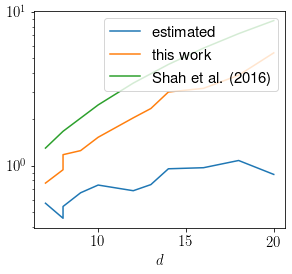

In [131]:
plt.figure(figsize=(4.5,4))
plt.plot(ds, np.quantile(l2es,0.95,axis=1), label=r'estimated')
# plt.fill_between(Ws, np.mean(l2es,1) + 2*np.std(l2es,1)/np.sqrt(n_iter),
#                 np.mean(l2es,1) - 2*np.std(l2es,1)/np.sqrt(n_iter), alpha=0.3)
plt.plot(ds, ds*np.quantile(kappa/lambdas_2_I*np.exp(-1.8), 0.95, axis=1), label=r'this work')
plt.plot(ds, ds/lambdas_2_L*np.exp(2), label=r'Shah et al. (2016)')
plt.xlabel(r'$d$'); plt.yscale("log"); plt.legend(loc='upper right')